<a href="https://colab.research.google.com/github/David-Almaguer-La-Rosa/Support-Vector-Machine-approach-for-automatic-image-classification/blob/main/Support_Vector_Machine_approach_for_automatic_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project I am going to code in Python how to develop a machine learning model to classify images automatically. 

With this objective, I am going to use the Support Vector Machine approach. First I will code and explain the binary approach, what is the base for Support Vector Machine multi-class classification.
Later, in the multiclass scene, I am going to implement and compare two models using scikit learn platform. First, **one vs the rest** methodology implemented through LinearSVC classifier and **one vs one** implemented through SVC classifier.

A theoretical reference can be reviewed at: https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b

**One vs. Rest Support Vector Machine** (binary approach)


In [18]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.datasets import load_digits
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [19]:
# load data
digits = load_digits()

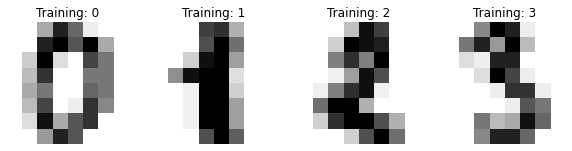

In [20]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [21]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [22]:
# Split data into 50% train and 50% test subsets
train_x, test_x, train_y, test_y = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

In [29]:
# build a function to create a classifier ("sklearn.svm.LinearSVC"), train the model and make predictions 

def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classification

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    clf = LinearSVC(C=0.1, random_state=0) # C factor multiplies the loss function and not the regularization part of the cost function, which means that it basically represents the inverse of lambda. We can think of c = 1/lambda.
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)
    return pred_test_y

In [24]:
# build a function to compute test error
def compute_test_error_svm(test_y_transformed, pred_test_y):
    return 1 - np.mean(pred_test_y == test_y_transformed)

From the binary classification point of view, we can build a one vs. rest model for every digit. In this way we would have N-class instances and  train N binary classifier models, for example, one of them could be classify the digits into two classes: 0 and not 0.
Here we go through this instances changing the labels of digits 1-9 to 1 and keeps the label 0 for digit 0 to train a binary classifier model. 


In [25]:
test_y_transformed = test_y.copy()
train_y_transformed = train_y.copy()

# building a function to develop a binary classifier model and compute the test error
def run_svm_one_vs_rest():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_y_transformed[train_y_transformed != 0] = 1
    test_y_transformed[test_y_transformed != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y_transformed, test_x)
    test_error = compute_test_error_svm(test_y_transformed, pred_test_y)
    return test_error, pred_test_y

test_error, pred_test_y = run_svm_one_vs_rest()
print('SVM one vs. rest test_error:', test_error)

SVM one vs. rest test_error: 0.008898776418242438


As an example, the first 10 images values are compared with the first 10 predicted values. Being the case of a binary classification, the prediction will return the value of 0 if the image corresponds to this number and the value of 1 if the image corresponds to a number between 1 and 9.

In [26]:
image_values = pd.DataFrame(test_y)
predictions = pd.DataFrame(pred_test_y)
compare = pd.concat([image_values, predictions], axis = 1, ignore_index=True)
compare.columns = ['image values', 'predictions']
(compare)

,image values,predictions
0,8,1
1,8,1
2,4,1
3,9,1
4,0,0
...,...,...
894,9,1
895,0,0
896,8,1
897,9,1


In [27]:
# obtain metrics for binary classifier model using LinearSVC
print(    
    f"{metrics.classification_report(test_y_transformed, pred_test_y)}\n"
)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        88
           1       1.00      0.99      1.00       811

    accuracy                           0.99       899
   macro avg       0.97      0.98      0.98       899
weighted avg       0.99      0.99      0.99       899




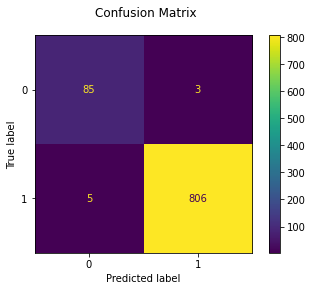

In [28]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y_transformed, pred_test_y)
disp.figure_.suptitle("Confusion Matrix")
#print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

**Linear SVM for multiclass classifciation using a *one-vs-rest* strategy**

Under the one-vs-rest approach (Rifkin and Klautau, 2004), the outputs of the k binary models are combined to generate multiclass predictions, as illustrated in the figure bellow.

<img src="https://www.researchgate.net/profile/Anders-Ringgaard-Kristensen/publication/257018675/figure/fig2/AS:667859080470545@1536241421780/The-considered-one-vs-all-multiclass-classification-approach.png" width='700'/>

Figure source: Escalante *et al.* (2013). Sow-activity classification from acceleration patterns: A machine learning approach. Computers and Electronics in Agriculture.

In [ ]:
# building a function for one vs rest strategy through "sklearn.svm.LinearSVC" model
def multi_class_svm_ovr(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf_ovr = LinearSVC(C=0.3, random_state=0)
    clf_ovr.fit(train_x, train_y)
    pred_test_y_multiclass_ovr = clf_ovr.predict(test_x)
    return pred_test_y_multiclass_ovr

pred_test_y_multiclass_ovr = multi_class_svm_ovr(train_x, train_y, test_x)

In [46]:
def compute_test_error_svm_multiclass(test_y, pred_test_y_multiclass_ovr):
    return 1 - np.mean(pred_test_y_multiclass_ovr == test_y)

compute_test_error_svm(test_y, pred_test_y_multiclass_ovr)

0.08898776418242493

In [47]:
# obtain metrics for a multiclass classifier model using a one-vs-rest strategy through "sklearn.svm.LinearSVC" model
print(    
    f"{metrics.classification_report(test_y, pred_test_y_multiclass_ovr)}\n"
)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95        88
           1       0.86      0.87      0.86        91
           2       0.96      0.99      0.97        86
           3       0.95      0.85      0.90        91
           4       0.98      0.93      0.96        92
           5       0.83      0.90      0.86        91
           6       0.95      0.99      0.97        91
           7       0.99      0.87      0.92        89
           8       0.87      0.84      0.86        88
           9       0.82      0.93      0.87        92

    accuracy                           0.91       899
   macro avg       0.91      0.91      0.91       899
weighted avg       0.91      0.91      0.91       899




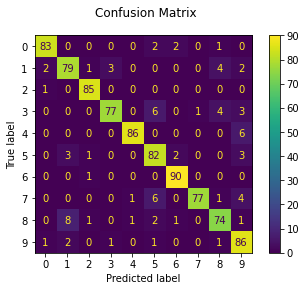

In [49]:
# print the confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y, pred_test_y_multiclass_ovr)
disp.figure_.suptitle("Confusion Matrix")
#print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

**SVM for multiclass classification using a *one-vs-one* strategy**

In [36]:
# building a function for one vs one strategy through "sklearn.svm.SVC" model
def multi_class_svm_ovo(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classification using a one-vs-one strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf_ovo = svm.SVC(gamma=0.001)
    clf_ovo.fit(train_x, train_y)
    pred_test_y_multiclass_ovo = clf_ovo.predict(test_x)
    return pred_test_y_multiclass_ovo

pred_test_y_multiclass_ovo = multi_class_svm_ovo(train_x, train_y, test_x)

In [37]:
def compute_test_error_svm_multiclass_ovo(test_y, pred_test_y_multiclass_ovo):
    return 1 - np.mean(pred_test_y_multiclass_ovo == test_y)

compute_test_error_svm_multiclass_ovo(test_y, pred_test_y_multiclass_ovo)

0.031145717463848754

In [38]:
# obtain metrics for a multiclass classifier model using a one-vs-one strategy through "sklearn.svm.SVC" model
print(    
    f"{metrics.classification_report(test_y, pred_test_y_multiclass_ovo)}\n"
)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




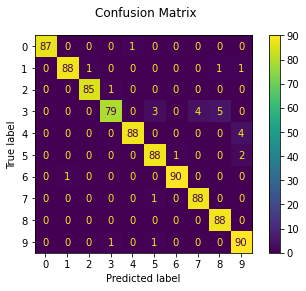

In [39]:
# print the confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y, pred_test_y_multiclass_ovo)
disp.figure_.suptitle("Confusion Matrix")
#print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


In conclusion, it can be established that the model generated with the one vs one strategy offers better classifications results **(accuracy = 0.97 and test error = 0.031)** than the model generated with the one vs rest strategy **(accuracy = 0.91 and test error = 0.088)**.